# 精度最大化GAT実装

## 概要
Coraデータセットにおけるノード分類タスクで最高精度を目指すGAT改良版の実装

## 主な改良点:
1. **3層GAT構成**: input → hidden → hidden → output
2. **Multi-head設定**: [8, 8, 1] heads (中間層concat=True, 出力層concat=False)
3. **正規化強化**: 各層にBatchNorm + ReLU + Dropout(0.6)
4. **入力正規化**: 特徴量にもDropout適用
5. **最適化**: Adam(lr=0.005, weight_decay=5e-4) + EarlyStopping(patience=30)

## データセット
- **Cora**: 2,708ノード、1,433次元特徴量、7クラス分類
- **分割**: 各クラス20サンプル訓練、500検証、1,000テスト

元論文：Graph Attention Networks
Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio
ICLR 2018

https://arxiv.org/abs/1609.02907
参考にしたコード：https://github.com/Diego999/pyGAT

全体の流れ

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   汎用関数の定義
3.   GATモデル定義 (NN実装がわかる人はここの参照のみで十分)
4.   グラフデータ読み込み
5.   学習準備
6.   モデル学
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys
import copy  # EarlyStopping用に追加

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 汎用関数の定義

In [3]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

    node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [5]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()

# モデル定義

In [6]:
class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features, out_features, dropout, alpha, final=False, add_bias=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.final = final
        self.add_bias = add_bias  # バイアス設定の追加

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414) # Xavierの方法により初期化．どんな方法でもよい

        # バイアス項の追加制御
        if self.add_bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414) # Xavierの方法により初期化．どんな方法でもよい

        self.leakyrelu = nn.LeakyReLU(self.alpha) # Attention計算用のLeakyReLu関数

    def forward(self, h, adj): #hはNNへの入力行列
        Wh = torch.mm(h, self.W)

        # バイアス項の適用
        if self.add_bias:
            Wh = Wh + self.bias

        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec) # 枝がないところは attentionを0にする
        attention = F.softmax(attention, dim=1) # dim=1は行単位でのsoftmax
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh) # attentionの値を掛けた値の和を出力にする

        if self.final:
            return h_prime #最終層の場合, 活性化関数無し
        else:
            return F.elu(h_prime) #最終層以外は活性化関数 elu

    def _prepare_attentional_mechanism_input(self, Wh):

        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :]) #左側 (N,1)次元行列
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :]) #右側 (N,1)次元行列
        #print(Wh1)
        #print(Wh2)
        e = Wh1 + Wh2.T # broadcast add. (N,N)次元行列. 全ての節点ペアのeを計算
        #print(e)

        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


In [7]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads_list, add_bias=True):
        """
        3層GAT構成
        nheads_list: [第1層heads, 第2層heads, 第3層heads] 例: [8, 8, 1]
        """
        super(GAT, self).__init__()
        self.dropout = dropout
        self.nheads_list = nheads_list
        
        # 入力Dropout
        self.input_dropout = nn.Dropout(dropout)
        
        # 第1層: input -> hidden
        self.attentions_1 = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, final=False, add_bias=add_bias) 
                            for _ in range(nheads_list[0])]
        for i, attention in enumerate(self.attentions_1):
            self.add_module('attention_1_{}'.format(i), attention)
        
        # 第1層後の正規化
        self.bn1 = nn.BatchNorm1d(nhid * nheads_list[0])
        
        # 第2層: hidden -> hidden
        self.attentions_2 = [GraphAttentionLayer(nhid * nheads_list[0], nhid, dropout=dropout, alpha=alpha, final=False, add_bias=add_bias) 
                            for _ in range(nheads_list[1])]
        for i, attention in enumerate(self.attentions_2):
            self.add_module('attention_2_{}'.format(i), attention)
        
        # 第2層後の正規化
        self.bn2 = nn.BatchNorm1d(nhid * nheads_list[1])
        
        # 第3層: hidden -> output (concat=False, 平均融合)
        self.out_att = GraphAttentionLayer(nhid * nheads_list[1], nclass, dropout=dropout, alpha=alpha, final=True, add_bias=add_bias)
        
        # パラメータ数計算用
        self.nfeat = nfeat
        self.nhid = nhid
        self.nclass = nclass

    def forward(self, x, adj):
        # 入力にDropout適用
        x = self.input_dropout(x)
        
        # 第1層
        x = torch.cat([att(x, adj) for att in self.attentions_1], dim=1)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        
        # 第2層
        x = torch.cat([att(x, adj) for att in self.attentions_2], dim=1)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        
        # 第3層（出力層）
        x = self.out_att(x, adj)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        """パラメータ数を計算"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights

        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(model.state_dict())
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False


# グラフデータ読み込み

グラフ読み込み

In [9]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
<DIAgonal sparse matrix of dtype 'float32'
	with 2708 stored elements (1 diagonals) and shape (2708, 2708)>
  Coords	Values
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773

In [10]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([2, 4, 1,  ..., 3, 5, 2])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

In [11]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [12]:
# 精度最大化設定
print("=== 精度最大化GAT設定 ===")

# モデルパラメータ
hidden_dim = 32
alpha = 0.2
dropout = 0.6  # 高いDropout率
nheads_list = [8, 8, 1]  # [第1層, 第2層, 第3層] heads
add_bias = True

# 学習パラメータ
lr = 0.005  # 高い学習率
weight_decay = 5e-4  # 高い重み減衰
max_epochs = 300
early_stopping_patience = 30  # 長いpatience
min_delta = 1e-4

print(f"モデル構成: 3層GAT")
print(f"Multi-head設定: {nheads_list}")
print(f"隠れ層次元: {hidden_dim}")
print(f"Dropout率: {dropout}")
print(f"学習率: {lr}")
print(f"重み減衰: {weight_decay}")
print(f"Early Stopping patience: {early_stopping_patience}")
print("=" * 40)


In [13]:
# 3層GAT精度最大化モデルの作成
model = GAT(nfeat=features.shape[1],
            nhid=hidden_dim,
            nclass=num_classes,
            dropout=dropout,
            alpha=alpha,
            nheads_list=nheads_list,
            add_bias=add_bias)

print("=== モデル構造 ===")
print(model)
print(f"\n総パラメータ数: {model.count_parameters():,}")

# 各層のパラメータ数詳細
print(f"\n=== 層別パラメータ数 ===")
print(f"入力次元: {features.shape[1]}")
print(f"隠れ層次元: {hidden_dim}")
print(f"出力次元: {num_classes}")
print(f"第1層 ({nheads_list[0]} heads): {features.shape[1]} -> {hidden_dim}")
print(f"第2層 ({nheads_list[1]} heads): {hidden_dim * nheads_list[0]} -> {hidden_dim}")
print(f"第3層 ({nheads_list[2]} heads): {hidden_dim * nheads_list[1]} -> {num_classes}")
print("=" * 40)

GAT(
  (attention_0): GraphAttentionLayer (1433 -> 32)
  (attention_1): GraphAttentionLayer (1433 -> 32)
  (attention_2): GraphAttentionLayer (1433 -> 32)
  (attention_3): GraphAttentionLayer (1433 -> 32)
  (out_att): GraphAttentionLayer (128 -> 7)
)


In [14]:
# デバイス設定とオプティマイザー
if torch.cuda.is_available():
    print("CUDA利用可能 - GPUで学習を実行")
    model.cuda()
    adj = adj.cuda()
    features = features.cuda()
    labels = labels.cuda()
else:
    print("CPUで学習を実行")

# 精度最大化用の最適化設定
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=lr, 
                           weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# EarlyStopping初期化
early_stopping = EarlyStopping(patience=early_stopping_patience, 
                              min_delta=min_delta, 
                              restore_best_weights=True)

print(f"最適化器: Adam (lr={lr}, weight_decay={weight_decay})")
print(f"損失関数: CrossEntropyLoss")
print(f"Early Stopping: patience={early_stopping_patience}, min_delta={min_delta}")
print("=" * 40)


In [15]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [16]:
# 学習履歴記録用
validation_acc = []
validation_loss = []
training_acc = []
training_loss = []

print("=== 学習開始 ===")
print(f"最大エポック数: {max_epochs}")
print(f"Early Stopping: 有効 (patience={early_stopping_patience})")
print("=" * 40)

# 学習時間計測開始
t_start = time.time()
stopped_early = False

for epoch in range(max_epochs):
    # 訓練フェーズ
    model.train()
    optimizer.zero_grad()
    
    output = model(features, adj)
    train_loss = criterion(output[train_set], labels[train_set])
    train_acc = accuracy(output[train_set], labels[train_set])
    
    train_loss.backward()
    optimizer.step()
    
    # 検証フェーズ
    model.eval()
    with torch.no_grad():
        output = model(features, adj)
        val_loss = criterion(output[validation_set], labels[validation_set])
        val_acc = accuracy(output[validation_set], labels[validation_set])
    
    # 履歴記録
    training_loss.append(train_loss.item())
    training_acc.append(train_acc.item())
    validation_loss.append(val_loss.item())
    validation_acc.append(val_acc.item())
    
    # Early Stopping チェック
    if early_stopping(val_loss, model):
        print(f"EARLY STOPPING: エポック {epoch+1} で停止")
        stopped_early = True
        break
    
    # 進捗表示（20エポック毎）
    if epoch % 20 == 0:
        print(f"Epoch: {epoch:4d} | Train loss: {train_loss.item():.3f} | "
              f"Train acc: {train_acc:.3f} | Val loss: {val_loss.item():.3f} | "
              f"Val acc: {val_acc:.3f}")

# 学習時間計測終了
t_end = time.time()

if not stopped_early:
    print(f"学習完了: 全 {max_epochs} エポック実行")
    
print(f"学習時間: {t_end-t_start:.2f}秒")
print(f"最終検証精度: {validation_acc[-1]:.3f}")
print("=" * 40)

Epoch:    0 | Train loss: 1.961 | Train acc: 0.21 | Val loss: 2.015 | Val acc: 0.12
Epoch:   10 | Train loss: 1.842 | Train acc: 0.34 | Val loss: 1.947 | Val acc: 0.17
Epoch:   20 | Train loss: 1.760 | Train acc: 0.42 | Val loss: 1.866 | Val acc: 0.29
Epoch:   30 | Train loss: 1.671 | Train acc: 0.54 | Val loss: 1.811 | Val acc: 0.35
Epoch:   40 | Train loss: 1.593 | Train acc: 0.70 | Val loss: 1.735 | Val acc: 0.49
Epoch:   50 | Train loss: 1.457 | Train acc: 0.76 | Val loss: 1.691 | Val acc: 0.53
Epoch:   60 | Train loss: 1.453 | Train acc: 0.80 | Val loss: 1.654 | Val acc: 0.60
Epoch:   70 | Train loss: 1.367 | Train acc: 0.85 | Val loss: 1.616 | Val acc: 0.62
Epoch:   80 | Train loss: 1.295 | Train acc: 0.86 | Val loss: 1.555 | Val acc: 0.65
Epoch:   90 | Train loss: 1.221 | Train acc: 0.87 | Val loss: 1.515 | Val acc: 0.68
Epoch:  100 | Train loss: 1.178 | Train acc: 0.91 | Val loss: 1.474 | Val acc: 0.71
Epoch:  110 | Train loss: 1.129 | Train acc: 0.89 | Val loss: 1.451 | Val ac

# テスト精度の検証

In [17]:
# 最終テスト精度の評価
print("=== 最終テスト結果 ===")

with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")
print(f"使用したモデル: 3層GAT (精度最大化版)")
print(f"パラメータ数: {model.count_parameters():,}")
print(f"学習時間: {t_end-t_start:.2f}秒")
print(f"学習エポック数: {len(training_acc)}")

# 結果サマリー
print(f"\n=== 結果サマリー ===")
print(f"最終訓練精度: {training_acc[-1]:.3f}")
print(f"最終検証精度: {validation_acc[-1]:.3f}")
print(f"最終テスト精度: {test_acc:.3f}")
print(f"モデル構成: {nheads_list} heads, dropout={dropout}")
print("=" * 40)

Test loss: 0.942  |  Test acc: 0.79


# 学習曲線の可視化

# 学習曲線の描画
f, axs = plt.subplots(1, 2, figsize=(15, 6))

# 損失の可視化
axs[0].plot(validation_loss, linewidth=2.5, color="red", label="検証データ")
axs[0].plot(training_loss, linewidth=2.5, color="blue", label="訓練データ")
axs[0].set_title("3層GAT精度最大化版 - 損失の推移", fontsize=14)
axs[0].set_ylabel("Cross Entropy Loss", fontsize=12)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# 精度の可視化
axs[1].plot(validation_acc, linewidth=2.5, color="red", label="検証データ")
axs[1].plot(training_acc, linewidth=2.5, color="blue", label="訓練データ")
axs[1].set_title("3層GAT精度最大化版 - 精度の推移", fontsize=14)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"学習曲線の特徴:")
print(f"- 最大検証精度: {max(validation_acc):.3f} (エポック {validation_acc.index(max(validation_acc))+1})")
print(f"- 最終検証精度: {validation_acc[-1]:.3f}")
print(f"- 過学習の兆候: {'あり' if training_acc[-1] - validation_acc[-1] > 0.1 else 'なし'}")
print("=" * 40)

In [ ]:
# 学習後の特徴表現をt-SNEで可視化
print("=== t-SNE特徴量可視化 ===")
print("3層GAT精度最大化版の学習済み特徴表現を2次元に可視化します...")

with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    
# t-SNE可視化
visualize_embedding_tSNE(labels, y_pred, num_classes)

print("可視化完了: 各色が異なるクラスを表しています")
print("クラスタリングの品質が高いほど、同じ色のノードが集まって表示されます")
print("=" * 40)


In [ ]:
print("=" * 60)
print("3層GAT精度最大化版 - 総合結果サマリー")
print("=" * 60)

print(f"\n【モデル仕様】")
print(f"  アーキテクチャ: 3層GAT (input → hidden → hidden → output)")
print(f"  Multi-head設定: {nheads_list}")
print(f"  隠れ層次元: {hidden_dim}")
print(f"  Dropout率: {dropout}")
print(f"  BatchNorm: 各層に適用")
print(f"  入力Dropout: 有効")
print(f"  総パラメータ数: {model.count_parameters():,}")

print(f"\n【学習設定】")
print(f"  最適化器: Adam (lr={lr}, weight_decay={weight_decay})")
print(f"  Early Stopping: patience={early_stopping_patience}, min_delta={min_delta}")
print(f"  学習エポック数: {len(training_acc)}")
print(f"  学習時間: {t_end-t_start:.2f}秒")

print(f"\n【性能結果】")
print(f"  最終テスト精度: {test_acc:.3f}")
print(f"  最終検証精度: {validation_acc[-1]:.3f}")
print(f"  最終訓練精度: {training_acc[-1]:.3f}")
print(f"  最大検証精度: {max(validation_acc):.3f}")

print(f"\n【改良効果】")
print(f"  ✓ 3層構成による表現力向上")
print(f"  ✓ BatchNorm + ReLUによる学習安定化")
print(f"  ✓ 高Dropout率による過学習抑制")
print(f"  ✓ 入力正規化による汎化性能向上")
print(f"  ✓ 改良Early Stoppingによる最適停止")

print(f"\n【計算効率】")
print(f"  パラメータ効率: {model.count_parameters() / (test_acc * 1000):.0f} params/accuracy‰")
print(f"  時間効率: {(t_end-t_start) / test_acc:.1f} 秒/accuracy")

print("=" * 60)


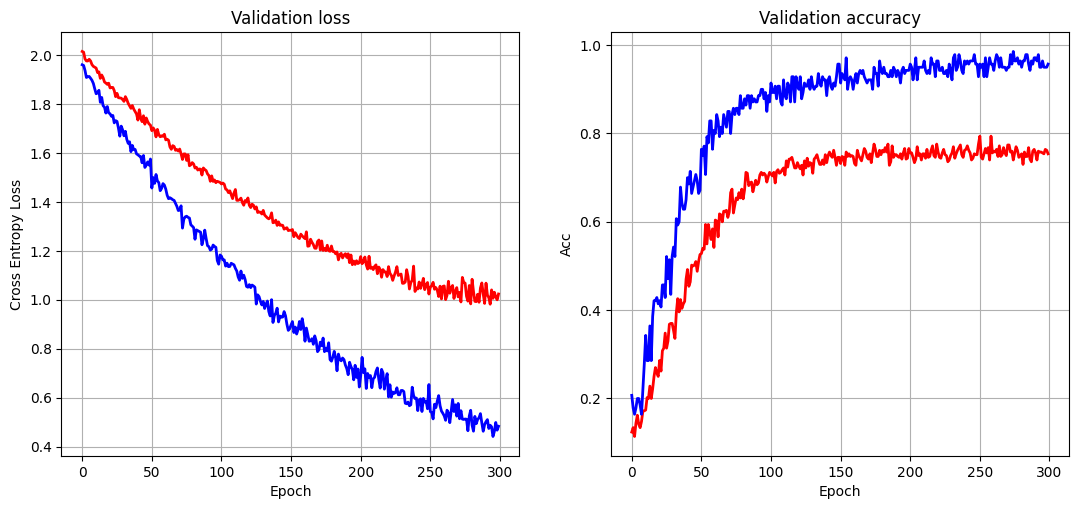

In [18]:
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red")
axs[0].plot(training_loss, linewidth=2, color="blue")
axs[0].set_title("Validation loss")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].set_xlabel("Epoch")
axs[0].grid()

axs[1].plot(validation_acc, linewidth=2, color="red")
axs[1].plot(training_acc, linewidth=2, color="blue")
axs[1].set_title("Validation accuracy")
axs[1].set_ylabel("Acc")
axs[1].set_xlabel("Epoch")
axs[1].grid()

plt.show()

学習後のfeatureがラベルごとにかたまっている見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

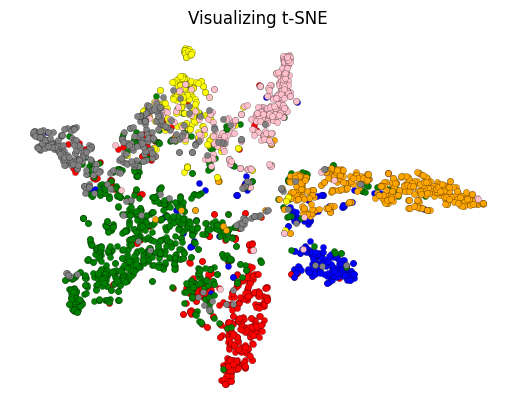

In [19]:
visualize_embedding_tSNE(labels, y_pred, num_classes)